# Get mass from power law fit to profile, extrapolated 

7/30/18: cleaned up and deleted a lot of cells

Notes from previous versions:

I am fitting between 50 and 100kpc and then extrapolating to 300kpc (previously 500, then 800, then inf), integrating from 100 to 300 to get the mass and then adding that to the mass at 100kpc given by galSBP. 

Using power law 2 (with a constant) fails often, either giving nan or not converging. Does not fit the profiles well at larger radii.

Power law over estimates the mass at larger radii. It seems that there is an additional component with a steeper slope past 100kpc but at a point which varies for each galaxy. A more precise fit with multiple components would be more useful (Raj's work)

In [1]:
import numpy as np
import h5py
import pickle
import matplotlib.pyplot as plt
from matplotlib import rcParams
import glob
import random

from scipy.optimize import curve_fit
from scipy.integrate import quad
from scipy.interpolate import interp1d

from astropy.table import Table

%matplotlib inline

rcParams['figure.figsize'] = [10., 8.]

In [2]:
def open_pkl(file_name):
    pkl = open(file_name,'rb')
    array = pickle.load(pkl)
    pkl.close()  
    return array

In [3]:
#open pickels
illustris_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_masses_quick.pkl'
illustris_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_isos_quick.pkl'

tng_masses_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_masses_quick.pkl'
tng_isos_file='/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_isos_quick.pkl'

def open_pkl(file_name):
    pkl = open(file_name,'rb')
    array = pickle.load(pkl)
    pkl.close()  
    return array

illustris_masses = open_pkl(illustris_masses_file)
tng_masses = open_pkl(tng_masses_file)
illustris_isos = open_pkl(illustris_isos_file)
tng_isos = open_pkl(tng_isos_file)

In [4]:
pixel_scale=2.*800./300 #kpc/pixel
print 'pixel scale: ', pixel_scale

pixel scale:  5.33333333333


In [5]:
#interpolated 1D mass
def oneD_mass(galaxy_iso, radius):
    mass=np.interp(radius,galaxy_iso['sma_kpc'], galaxy_iso['growth_ori'])
    return np.log10(mass)

# def powerlaw(x, m, c, c0):
#     return c0 + x**m * c
def powerlaw(x, m, c):
    return x**m * c

def ellipse_perimeter(a,b):
    '''perimeter of an ellipse from Ramanujan's approximation'''
    perimeter = np.pi * ( 3*(a+b) - np.sqrt( (3*a + b) * (a + 3*b) ) )
    return perimeter

def mass_per_r(r, power_law_params, e):   
    q=1-e
    b=r*q
    return powerlaw(r,*power_law_params)*ellipse_perimeter(r,b)

def fit_power_law_to_iso(iso, ini_r, final_r):
    
    x=iso['sma_kpc'][(iso['sma_kpc']>ini_r) & (iso['sma_kpc']<final_r)]
    y=iso['intens_kpc'][(iso['sma_kpc']>ini_r) & (iso['sma_kpc']<final_r)]
    
    p_fit_power, _ = curve_fit(powerlaw, x, y, p0=[-2,10**10])
    
    return p_fit_power

def extrapolated_1D_mass(iso, max_r):

    #fit power law between 50 and 100kpc
    p_fit_power = fit_power_law_to_iso(iso, 50, 100)

    #print p_fit_power

    #integrate between 100 and mak_r to get mass
    e = iso['ell'][1]
    mass_beyond100, mass_err =quad(mass_per_r, 100, max_r, args=tuple([p_fit_power, e]))

    #add to galSBP mass to get total mass
    mass_100 = 10**(oneD_mass(iso, 100))
    power_law_fit_mass = np.log10(mass_100+mass_beyond100)

    return power_law_fit_mass

def mu_iso(iso, pixel_scale):
    return 10**(np.log10(iso['intens'] / (pixel_scale**2.0))+ np.log10(0.7 ** 2.0))

def mu_extrap(iso, ini_r=50, final_r=100):
    power_law_iso = np.log10(powerlaw(iso['sma_kpc'],*fit_power_law_to_iso(iso, ini_r, final_r)))
    return 10**(power_law_iso+ np.log10(0.7 ** 2.0))

def get_median_profile(isos, pixel_scale, quantity = 'intens', rmin=0.05, rmax=4.7, nbin=150):
    """Get the median profiles."""
    sma_common = np.linspace(rmin, rmax, nbin)

    if quantity == 'intens':
        mu = np.nanmedian(np.stack([interp1d((gal['sma'] * pixel_scale) ** 0.25,
                                               np.log10(gal[quantity] / (pixel_scale ** 2)),
                                               bounds_error=False,
                                               fill_value=np.nan,
                                               kind='slinear')(sma_common)
                               for gal in isos]), axis=0)
    elif quantity == 'intens_kpc':
        mu = np.nanmedian(np.stack([interp1d((gal['sma_kpc']) ** 0.25,
                                               np.log10(gal[quantity]),
                                               bounds_error=False,
                                               fill_value=np.nan,
                                               kind='slinear')(sma_common)
                               for gal in isos]), axis=0)
    elif quantity == 'growth_ori':
        mu = np.nanmedian(np.stack([interp1d((gal['sma_kpc']) ** 0.25,
                                               np.log10(gal[quantity]),
                                               bounds_error=False,
                                               fill_value=np.nan,
                                               kind='slinear')(sma_common)
                               for gal in isos]), axis=0)
    elif quantity == 'extrapolated':
        mu = np.nanmedian(np.stack([interp1d((gal['sma_kpc']) ** 0.25,
                                               np.log10(mu_extrap(gal)),
                                               bounds_error=False,
                                               fill_value=np.nan,
                                               kind='slinear')(sma_common)
                               for gal in isos]), axis=0)
    elif quantity == 'ratio':
        mu = np.nanmedian(np.stack([interp1d((gal['sma'] * pixel_scale) ** 0.25,
                                               mu_extrap(gal)/mu_iso(gal, pixel_scale),
                                               bounds_error=False,
                                               fill_value=np.nan,
                                               kind='slinear')(sma_common)
                               for gal in isos]), axis=0)

    return sma_common, mu


### from Song's galSBP code, adjusted, not used in notebook. more useful for summing than integrating

In [6]:
def integrate_mass(iso, fit_params):
    """
    Extract growth curve from Ellipse output.

    Parameters:
    """
    r = ellipOut['sma']
    e = ellipOut['ell']
    
    
    intens = powerlaw(r,fit_params)
    

    # The area in unit of pixels covered by an elliptical isophote
    ellArea = np.pi * ((r ** 2.0) * (1.0 - e))
    # The area in unit covered by the "ring"
    # isoArea = np.append(ellArea[0], [ellArea[1:] - ellArea[:-1]])
    # The total flux inside the "ring"

    isoFlux = np.append(ellArea[0], [ellArea[1:] - ellArea[:-1]]) * intens

        
    # Get the growth Curve
    curveOfGrowth = np.asarray(map(lambda x: np.nansum(isoFlux[0:x + 1]),
                               range(isoFlux.shape[0])))


#     indexMax = np.argmax(curveOfGrowth)
#     maxIsoSma = ellipOut['sma'][indexMax]
#     maxIsoFlux = curveOfGrowth[indexMax]

    return mass

# TNG 

## pick 5 randoms

In [7]:
#pick 5 random
np.random.seed(92)
random_indices_tng = np.random.randint(0, len(tng_masses), size=5)
print random_indices_tng

random_isos_tng = [tng_isos[i] for i in random_indices_tng]
random_masses_tng = [tng_masses[i] for i in random_indices_tng]

[122  42  67  18 139]


## plot profiles

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


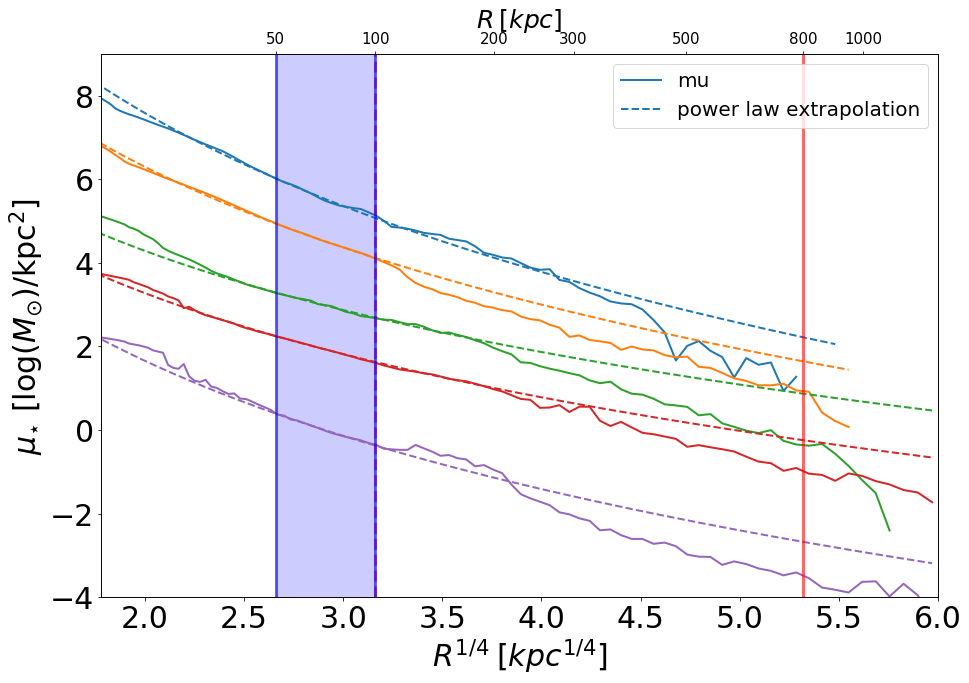

In [8]:
initial_r, final_r =50, 100
    
#plot
ngals1=0

#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()


######################################################################################################################
# plot
######################################################################################################################

for i, iso in enumerate(random_isos_tng):   

        ngals1+=1

        mu_plot = ax1.plot((iso['sma'] * pixel_scale) ** 0.25, np.log10(mu_iso(iso, pixel_scale))-i*1.5, 
                           linewidth=2, alpha=1, label='mu', zorder=1)
        ax1.plot((iso['sma'] * pixel_scale) ** 0.25, np.log10(mu_extrap(iso,initial_r, final_r))-i*1.5, 
                 linewidth=2, linestyle='--', alpha=1, c=mu_plot[0].get_color(), label='power law extrapolation', 
                 zorder=1)



## median profiles for illustris
# median_sma1, median_mu1 = get_median_profile(illustris_isos, quantity = 'ratio',
#                                              pixel_scale = pixel_scale, rmin=50**0.25, rmax=800.**0.25)

#ax1.plot(median_sma1, median_mu1, linewidth=4.0, c=u'#d62728', alpha=1, label='Illustris', zorder=8)


#     print ngals1


# ######################################################################################################################
# # plot details
# ######################################################################################################################
# # X-Y limits
ax1.set_xlim(10**0.25, 6)
ax1.set_ylim(-4, 9)

# Labels
ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
               size=60)
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[:2], labels[:2], fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([50**0.25, 100**0.25, 200**0.25, 300**0.25, 500**0.25, 800**0.25, 1000**0.25])
ax1_twin.xaxis.set_ticklabels([50, 100, 200, 300, 500, 800, 1000])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
#ax1.set_title('5 randomly selected profiles and extrapolations', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

ax1.axvline(initial_r ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='b')
ax1.axvline(final_r ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='b')
ax1.axvspan(initial_r** 0.25, final_r** 0.25, alpha=0.2, color='b')

######################################################################################################################
#adjustments to ticks and space between subplots

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_Illustris.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

## check ratios 

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in divide
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in divide


235


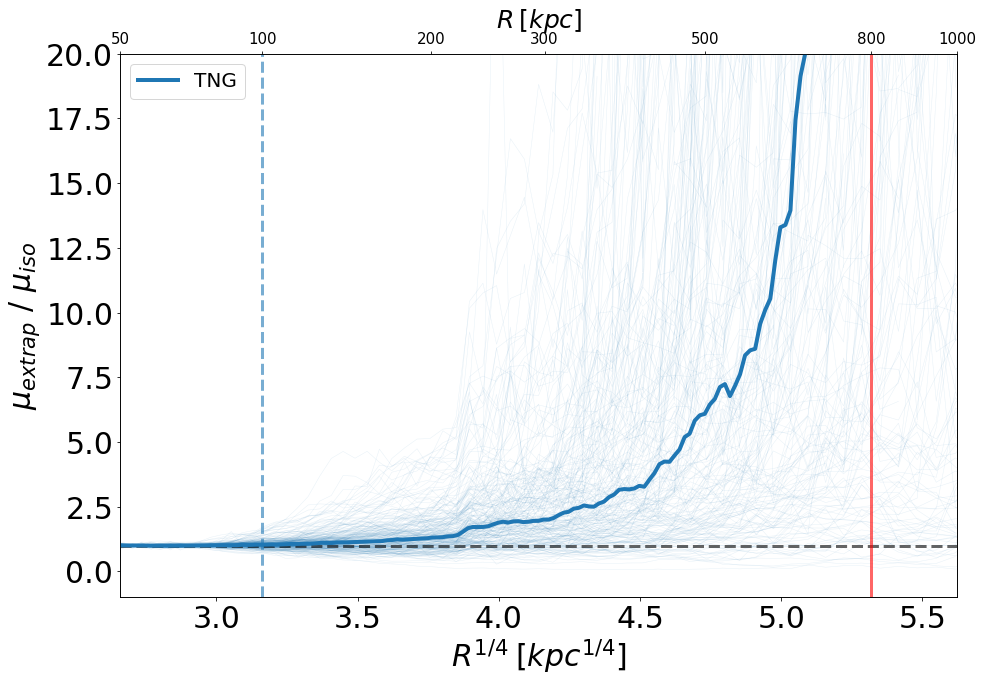

In [9]:
ngals1=0

#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()


######################################################################################################################
# plot
######################################################################################################################

for iso in tng_isos:   
    

        ngals1+=1
        
        #calculate ratio of mus
        ratio = mu_extrap(iso) / mu_iso(iso, pixel_scale)

        ax1.plot((iso['sma'] * pixel_scale) ** 0.25, ratio , linewidth=0.5, c=u'#1f77b4', alpha=0.1, 
                 label='_nolegend_', zorder=1)
                 #label='TNG Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))


## median profiles for tng
median_sma1, median_mu1 = get_median_profile(tng_isos, quantity = 'ratio',
                                             pixel_scale = pixel_scale, rmin=50**0.25, rmax=800.**0.25)

ax1.plot(median_sma1, median_mu1, linewidth=4.0, c=u'#1f77b4', alpha=1, label='TNG', zorder=8)


print ngals1


# ######################################################################################################################
# # plot details
# ######################################################################################################################
# # X-Y limits
ax1.set_xlim(50**0.25, 1000**0.25)
ax1.set_ylim(-1, 20)

# Labels
ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

ax1.legend(fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([50**0.25, 100**0.25, 200**0.25, 300**0.25, 500**0.25, 800**0.25, 1000**0.25])
ax1_twin.xaxis.set_ticklabels([50, 100, 200, 300, 500, 800, 1000])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{extrap} \ / \ \mu_{iso} $', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axhline(1., linestyle='--', linewidth=3.0, alpha=0.6, c='k', zorder=1)

######################################################################################################################
#adjustments to ticks and space between subplots

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_TNG.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

## get extrapolated masses out to r and 1D mass out to r

In [39]:
r=400

In [40]:
random_catalog_masses_tng = np.array([tng_masses[i][0] for i in random_indices_tng])
random_extrapolated_masses_tng=[]
for iso in random_isos_tng:
    mass = extrapolated_1D_mass(iso, r)
    random_extrapolated_masses_tng.append(mass)

random_extrapolated_masses_tng = np.array(random_extrapolated_masses_tng)

In [41]:
#1D mass out to 300kpc
oned_masses_tng=np.array([oneD_mass(iso,r) for iso in tng_isos])
random_oned_masses_tng=np.array([oneD_mass(iso,r) for iso in random_isos_tng])

In [42]:
tng_catalog_masses = np.array([m[0] for m in tng_masses])
tng_extrapolated_masses=[]
for iso in tng_isos:
    mass = extrapolated_1D_mass(iso, r)
    tng_extrapolated_masses.append(mass)

tng_extrapolated_masses = np.array(tng_extrapolated_masses)

#save extrapolated masses
# np.save('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_extrapolated_masses.npy',
#         extrapolated_masses)
# np.save('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/TNG/TNG_catalog_masses.npy',
#         catalog_masses)

<function matplotlib.pyplot.show>

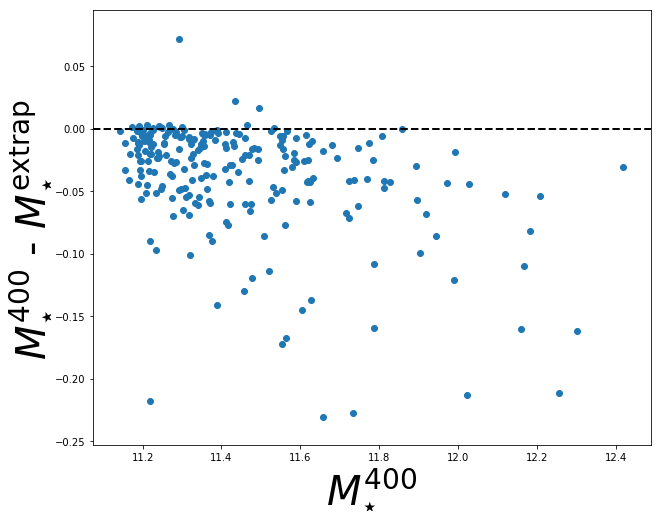

In [48]:
# #fit line
# illustris_diff_cat_1dextrap_params = np.polyfit(catalog_masses, catalog_masses - extrapolated_masses , 1)
# illustris_diff_cat_1dextrap_line = np.poly1d(illustris_diff_cat_1dextrap_params)
# xs=np.linspace(11.2,12.4, 100)



plt.scatter(oned_masses_tng, oned_masses_tng-tng_extrapolated_masses)
#plt.scatter(random_oned_masses_tng, random_oned_masses_tng-random_extrapolated_masses_tng, c='r')

# plt.scatter(tng_catalog_masses, tng_catalog_masses-tng_extrapolated_masses)
# plt.scatter(random_catalog_masses_tng, random_catalog_masses_tng-random_extrapolated_masses_tng, c='r')

# plt.plot(xs, illustris_diff_cat_1dextrap_line(xs))
# plt.text(12, 0.05,'slope: ' + str(illustris_diff_cat_1dextrap_params[0]), fontsize=15)

# plt.ylim([-0.5,0.1])

plt.axhline(0,c="k",linewidth=2,linestyle='--')
plt.ylabel(r'$M_{\star}^{\mathrm{400}}$ - $M_{\star}^{\mathrm{{extrap}}}$ ', fontsize=40)
plt.xlabel('$M_{\star}^{\mathrm{400}}$', fontsize=40)
plt.show

# Illustris

## pick 5 randoms

In [14]:
#pick 5 random
np.random.seed(92)
random_indices_illustris = np.random.randint(0, len(illustris_masses), size=5)
print random_indices_illustris

random_isos_illustris = [illustris_isos[i] for i in random_indices_illustris]
random_masses_illustris = [illustris_masses[i] for i in random_indices_illustris]

[122  42 323  18 198]


## plot profiles

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:19: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':


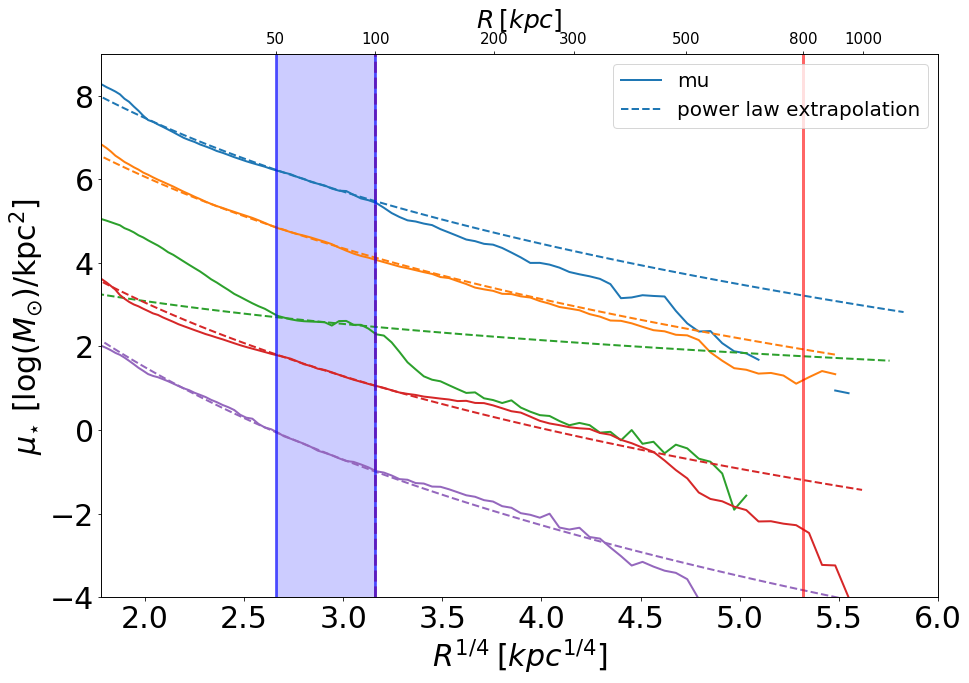

In [15]:
initial_r, final_r =50, 100
    
#plot
ngals1=0

#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()


######################################################################################################################
# plot
######################################################################################################################

for i, iso in enumerate(random_isos_illustris):   

        ngals1+=1

        mu_plot = ax1.plot((iso['sma'] * pixel_scale) ** 0.25, np.log10(mu_iso(iso, pixel_scale))-i*1.5, 
                           linewidth=2, alpha=1, label='mu', zorder=1)
        ax1.plot((iso['sma'] * pixel_scale) ** 0.25, np.log10(mu_extrap(iso,initial_r, final_r))-i*1.5, 
                 linewidth=2, linestyle='--', alpha=1, c=mu_plot[0].get_color(), label='power law extrapolation', 
                 zorder=1)



## median profiles for illustris
# median_sma1, median_mu1 = get_median_profile(illustris_isos, quantity = 'ratio',
#                                              pixel_scale = pixel_scale, rmin=50**0.25, rmax=800.**0.25)

#ax1.plot(median_sma1, median_mu1, linewidth=4.0, c=u'#d62728', alpha=1, label='Illustris', zorder=8)


#     print ngals1


# ######################################################################################################################
# # plot details
# ######################################################################################################################
# # X-Y limits
ax1.set_xlim(10**0.25, 6)
ax1.set_ylim(-4, 9)

# Labels
ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
               size=60)
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[:2], labels[:2], fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([50**0.25, 100**0.25, 200**0.25, 300**0.25, 500**0.25, 800**0.25, 1000**0.25])
ax1_twin.xaxis.set_ticklabels([50, 100, 200, 300, 500, 800, 1000])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
#ax1.set_title('5 randomly selected profiles and extrapolations', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

ax1.axvline(initial_r ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='b')
ax1.axvline(final_r ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='b')
ax1.axvspan(initial_r** 0.25, final_r** 0.25, alpha=0.2, color='b')

######################################################################################################################
#adjustments to ticks and space between subplots

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_Illustris.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

## check ratios 

/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: divide by zero encountered in power
  if __name__ == '__main__':
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:48: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in divide
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: divide by zero encountered in divide


339


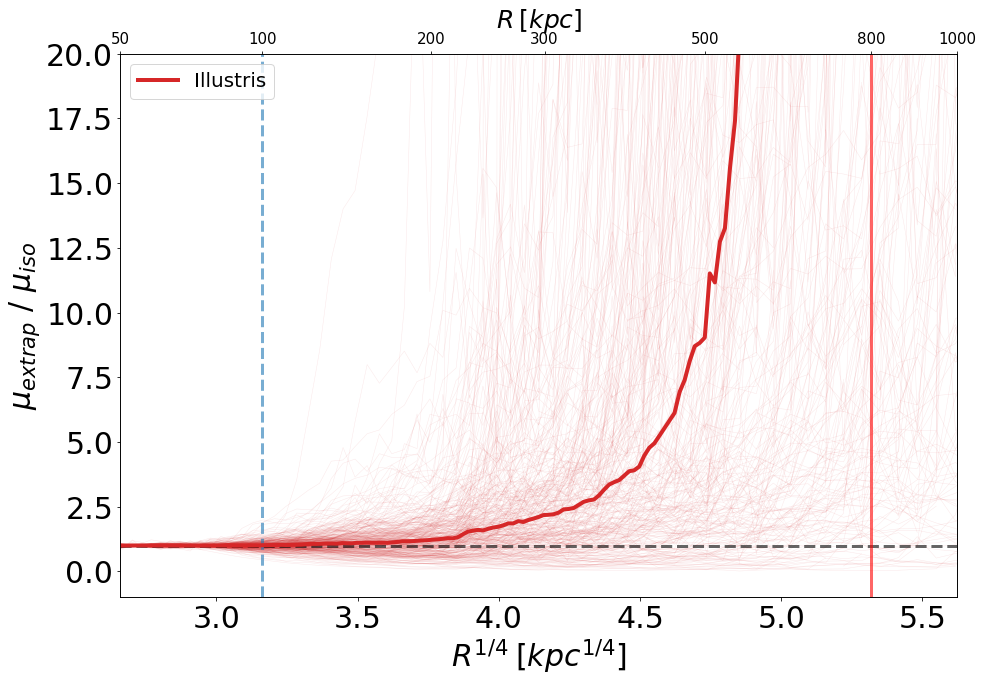

In [16]:
ngals1=0

#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()


######################################################################################################################
# plot
######################################################################################################################

for iso in illustris_isos:   
    

        ngals1+=1
        
        #calculate ratio of mus
        ratio = mu_extrap(iso) / mu_iso(iso, pixel_scale)

        ax1.plot((iso['sma'] * pixel_scale) ** 0.25, ratio , linewidth=0.5, c=u'#d62728', alpha=0.1, 
                 label='_nolegend_', zorder=1)
                 #label='Illustris Galaxy '+str(i)+': $M_{\star} = $'+str(round(m_star,1)))


## median profiles for illustris
median_sma1, median_mu1 = get_median_profile(illustris_isos, quantity = 'ratio',
                                             pixel_scale = pixel_scale, rmin=50**0.25, rmax=800.**0.25)

ax1.plot(median_sma1, median_mu1, linewidth=4.0, c=u'#d62728', alpha=1, label='Illustris', zorder=8)


print ngals1


# ######################################################################################################################
# # plot details
# ######################################################################################################################
# # X-Y limits
ax1.set_xlim(50**0.25, 1000**0.25)
ax1.set_ylim(-1, 20)

# Labels
ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

ax1.legend(fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([50**0.25, 100**0.25, 200**0.25, 300**0.25, 500**0.25, 800**0.25, 1000**0.25])
ax1_twin.xaxis.set_ticklabels([50, 100, 200, 300, 500, 800, 1000])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{extrap} \ / \ \mu_{iso} $', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6)
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axhline(1., linestyle='--', linewidth=3.0, alpha=0.6, c='k', zorder=1)

######################################################################################################################
#adjustments to ticks and space between subplots

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_Illustris.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

## get extrapolated masses out to 300kpc

In [17]:
random_catalog_masses_illustris = np.array([illustris_masses[i][0] for i in random_indices_illustris])
random_extrapolated_masses_illustris=[]
for iso in random_isos_illustris:
    mass = extrapolated_1D_mass(iso, 300)
    random_extrapolated_masses_illustris.append(mass)

random_extrapolated_masses_illustris = np.array(random_extrapolated_masses_illustris)

In [18]:
illustris_catalog_masses = np.array([m[0] for m in illustris_masses])
illustris_extrapolated_masses=[]
for iso in illustris_isos:
    mass = extrapolated_1D_mass(iso, 300)
    illustris_extrapolated_masses.append(mass)

illustris_extrapolated_masses = np.array(illustris_extrapolated_masses)

#save extrapolated masses
# np.save('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_extrapolated_masses.npy',
#         extrapolated_masses)
# np.save('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Data/Illustris/Illustris_catalog_masses.npy',
#         catalog_masses)

<function matplotlib.pyplot.show>

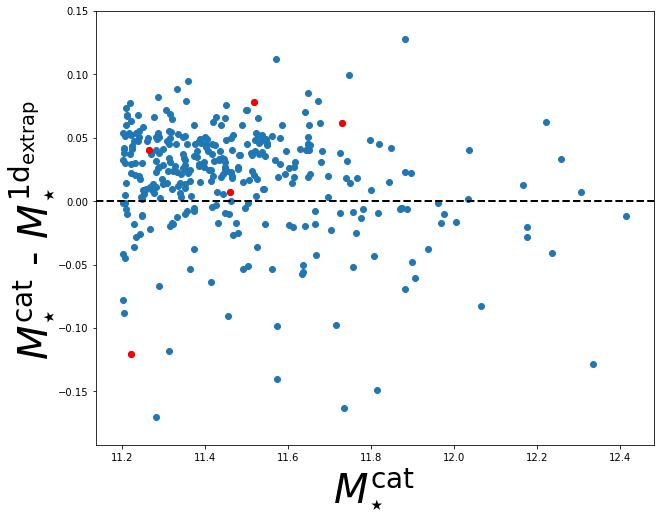

In [19]:
# #fit line
# illustris_diff_cat_1dextrap_params = np.polyfit(catalog_masses, catalog_masses - extrapolated_masses , 1)
# illustris_diff_cat_1dextrap_line = np.poly1d(illustris_diff_cat_1dextrap_params)
# xs=np.linspace(11.2,12.4, 100)



plt.scatter(illustris_catalog_masses, illustris_catalog_masses-illustris_extrapolated_masses)
plt.scatter(random_catalog_masses_illustris, random_catalog_masses_illustris-random_extrapolated_masses_illustris, c='r')

# plt.plot(xs, illustris_diff_cat_1dextrap_line(xs))
# plt.text(12, 0.05,'slope: ' + str(illustris_diff_cat_1dextrap_params[0]), fontsize=15)

# plt.ylim([-0.5,0.1])

plt.axhline(0,c="k",linewidth=2,linestyle='--')
plt.ylabel(r'$M_{\star}^{\mathrm{cat}}$ - $M_{\star}^{\mathrm{1d_{extrap}}}$ ', fontsize=40)
plt.xlabel('$M_{\star}^{\mathrm{cat}}$', fontsize=40)
plt.show

# %%%%%%%%Testing area %%%%%%%%%%

## varying fitting range 
seems to work best around 50-100 kpc range

r_initial = 10.0, r_final = 60.0


/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


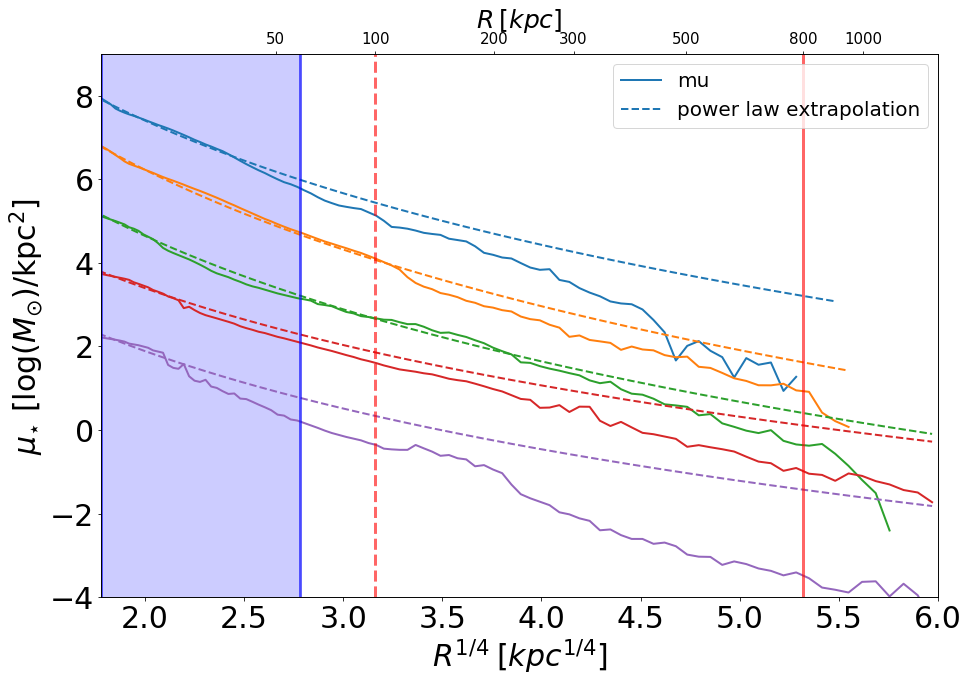

r_initial = 20.0, r_final = 70.0


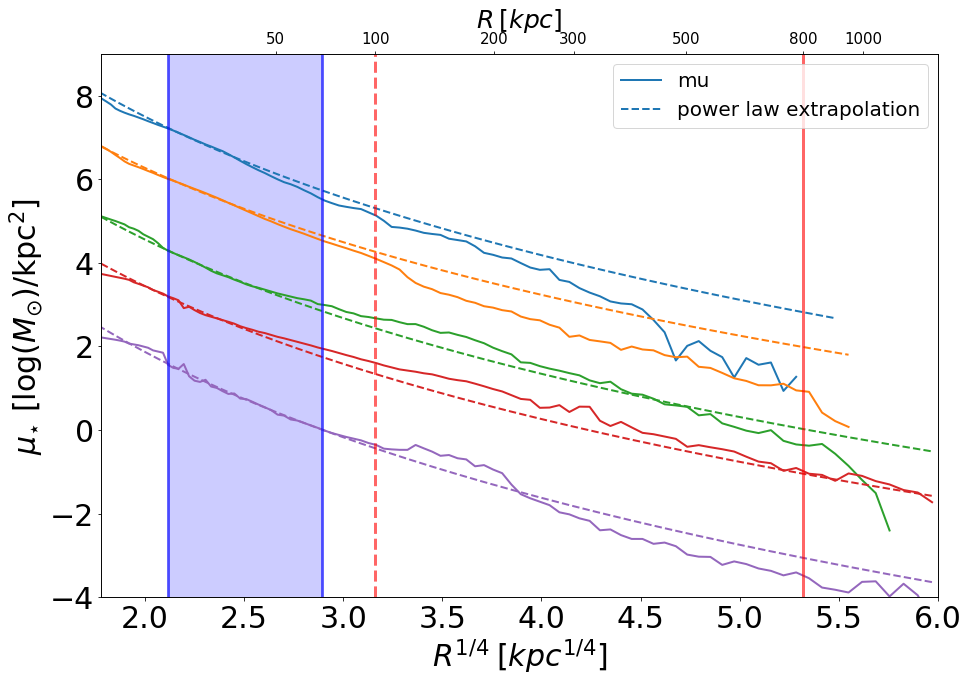

r_initial = 30.0, r_final = 80.0


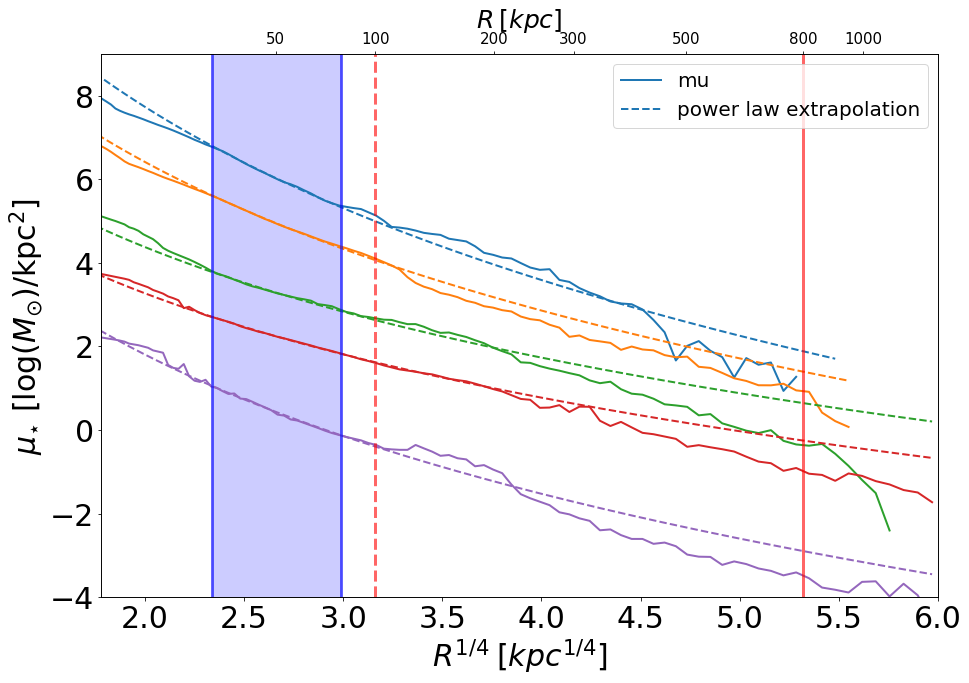

r_initial = 40.0, r_final = 90.0


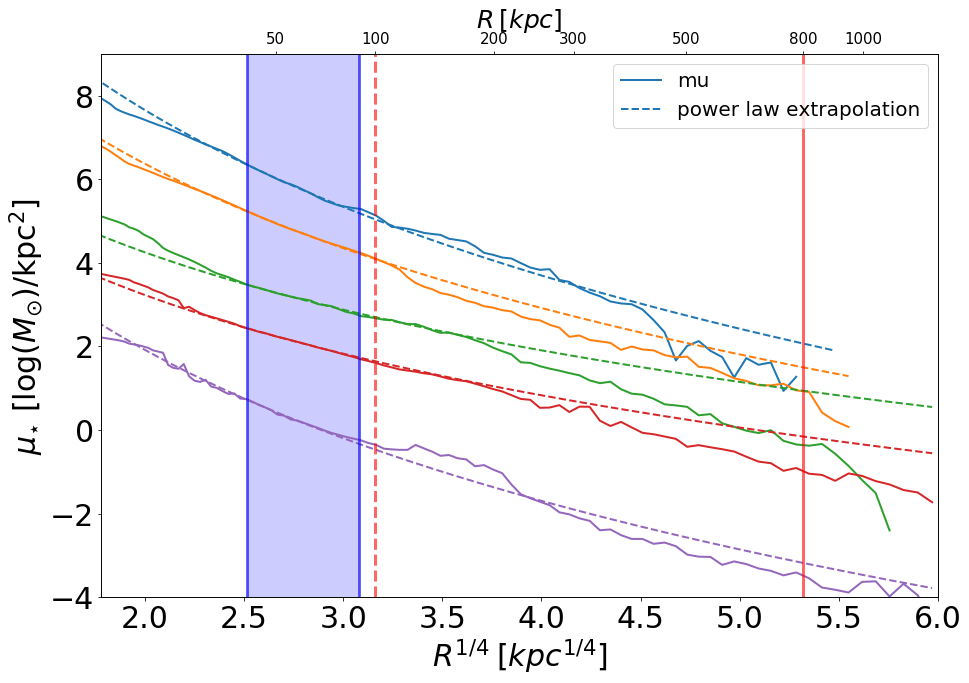

r_initial = 50.0, r_final = 100.0


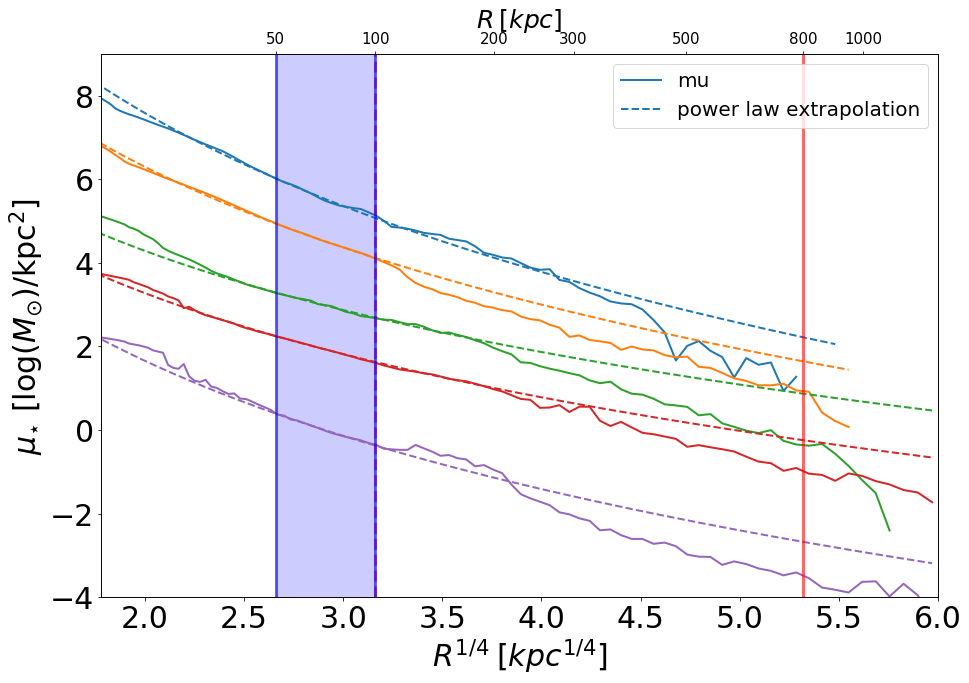

r_initial = 60.0, r_final = 110.0


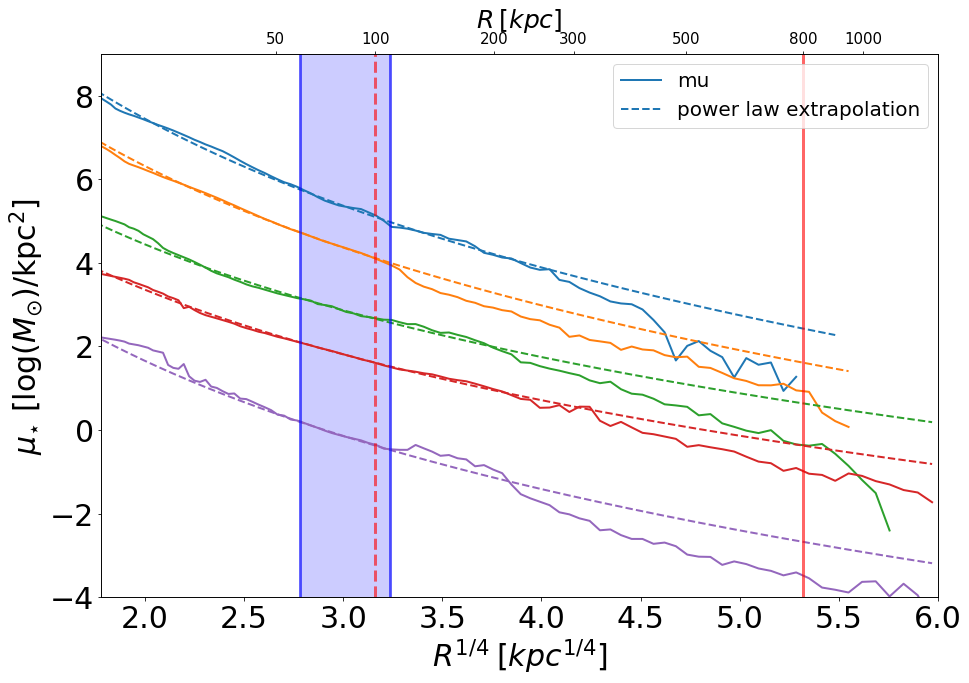

r_initial = 70.0, r_final = 120.0


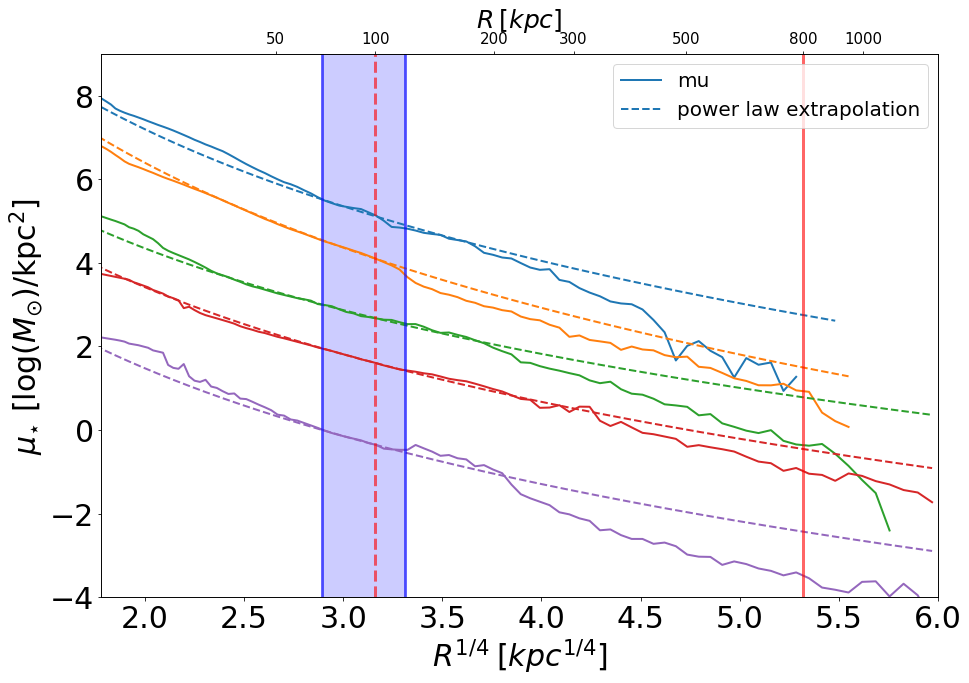

r_initial = 80.0, r_final = 130.0


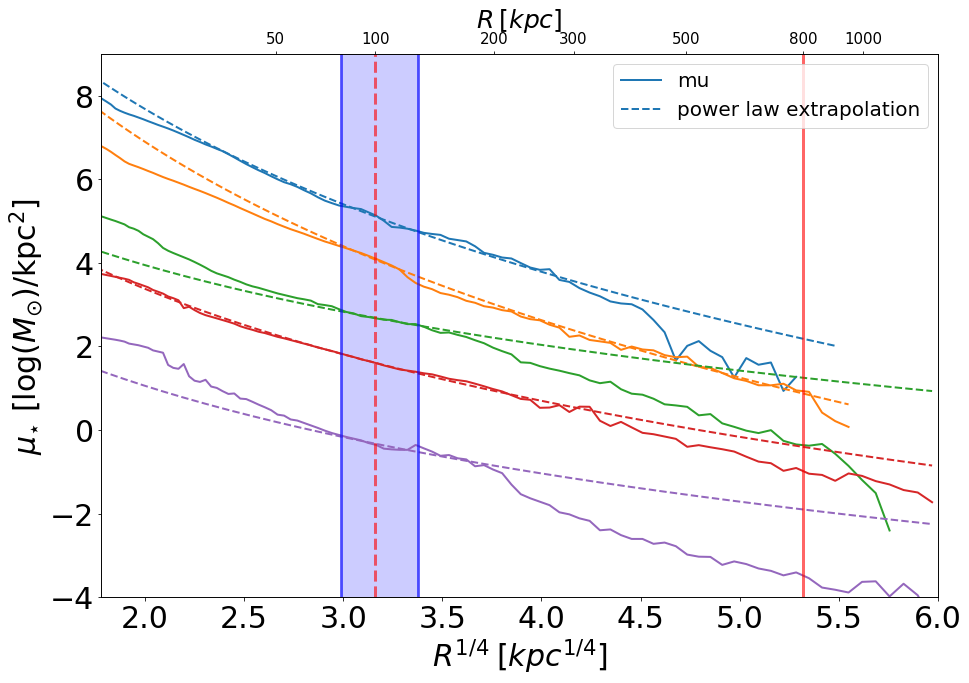

r_initial = 90.0, r_final = 140.0


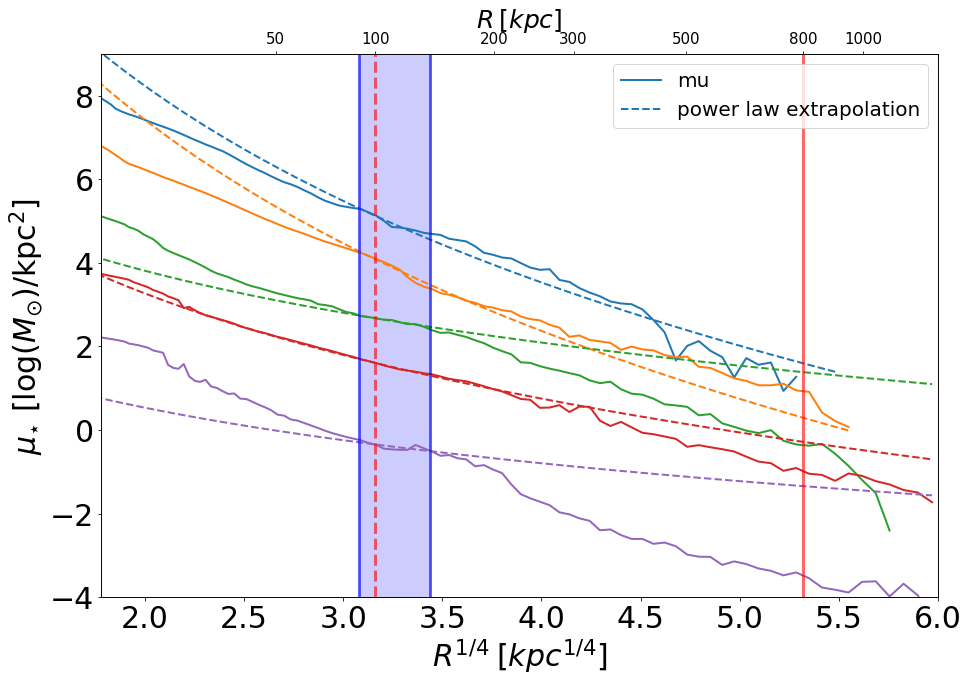

r_initial = 100.0, r_final = 150.0


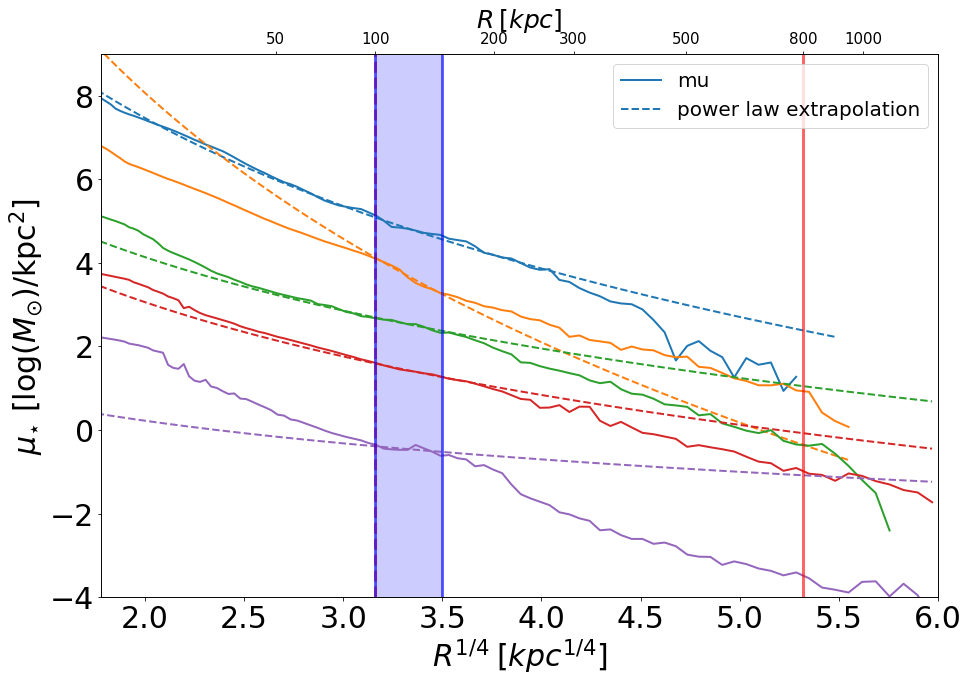

In [86]:
for initial_r, final_r in zip(initial_rs, final_rs): 
    
    print 'r_initial = {0}, r_final = {1}'.format(initial_r, final_r)
    
    #plot
    ngals1=0

    #plot
    fig =plt.figure(figsize=(15, 10))
    ax1 = plt.subplot()


######################################################################################################################
# plot
######################################################################################################################

    for i, iso in enumerate(random_isos):   

            ngals1+=1

            mu_plot = ax1.plot((iso['sma'] * pixel_scale) ** 0.25, np.log10(mu_iso(iso, pixel_scale))-i*1.5, 
                               linewidth=2, alpha=1, label='mu', zorder=1)
            ax1.plot((iso['sma'] * pixel_scale) ** 0.25, np.log10(mu_extrap(iso,initial_r, final_r))-i*1.5, 
                     linewidth=2, linestyle='--', alpha=1, c=mu_plot[0].get_color(), label='power law extrapolation', 
                     zorder=1)



    ## median profiles for illustris
    # median_sma1, median_mu1 = get_median_profile(illustris_isos, quantity = 'ratio',
    #                                              pixel_scale = pixel_scale, rmin=50**0.25, rmax=800.**0.25)

    #ax1.plot(median_sma1, median_mu1, linewidth=4.0, c=u'#d62728', alpha=1, label='Illustris', zorder=8)


#     print ngals1


    # ######################################################################################################################
    # # plot details
    # ######################################################################################################################
    # # X-Y limits
    ax1.set_xlim(10**0.25, 6)
    ax1.set_ylim(-4, 9)

    # Labels
    ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
                   size=60)
    ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
                   size=60)
    ax1.tick_params(axis='both', which='major', labelsize=30)

    #text label
    #ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

    handles, labels = ax1.get_legend_handles_labels()
    ax1.legend(handles[:2], labels[:2], fontsize=20)

    #add twin x axis in kpc
    x1, x2 = ax1.get_xlim()
    ax1_twin = ax1.twiny()
    ax1_twin.set_xlim(x1, x2)
    ax1_twin.figure.canvas.draw()
    ax1_twin.xaxis.set_ticks([50**0.25, 100**0.25, 200**0.25, 300**0.25, 500**0.25, 800**0.25, 1000**0.25])
    ax1_twin.xaxis.set_ticklabels([50, 100, 200, 300, 500, 800, 1000])
    ax1_twin.tick_params(axis='both', which='major', labelsize=15)
    ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

    ######################################################################################################################

    #axis labels and vertical lines
    ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
    ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
    #ax1.set_title('5 randomly selected profiles and extrapolations', fontsize=30)
    ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6, c='r')
    ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
    ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
    
    ax1.axvline(initial_r ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='b')
    ax1.axvline(final_r ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='b')
    ax1.axvspan(initial_r** 0.25, final_r** 0.25, alpha=0.2, color='b')

    ######################################################################################################################
    #adjustments to ticks and space between subplots

    # fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_Illustris.pdf',
    #             dpi=100, format='pdf', bbox_inches='tight')

    plt.show()

## try 2 components:
hard to find fitting range for second component that is applicable to all 5. probably easier to get a better fitting form.

r_initial = 100.0, r_final = 150.0


/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log10
  
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:22: RuntimeWarning: divide by zero encountered in log10
/Users/fardila/anaconda/envs/hsc_hydro/lib/python2.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in power
  after removing the cwd from sys.path.


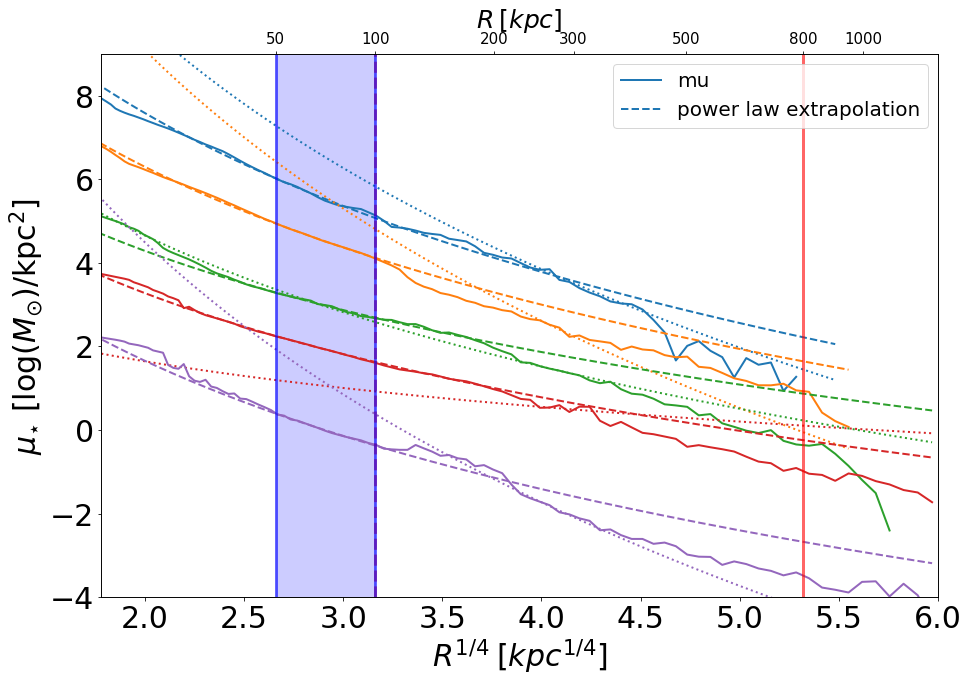

In [87]:
initial_r1, final_r1 = 50, 100
initial_r2, final_r2 = 250, 300
    
print 'r_initial = {0}, r_final = {1}'.format(initial_r, final_r)

#plot
ngals1=0

#plot
fig =plt.figure(figsize=(15, 10))
ax1 = plt.subplot()


######################################################################################################################
# plot
######################################################################################################################

for i, iso in enumerate(random_isos):   

        ngals1+=1

        mu_plot = ax1.plot((iso['sma'] * pixel_scale) ** 0.25, np.log10(mu_iso(iso, pixel_scale))-i*1.5, 
                           linewidth=2, alpha=1, label='mu', zorder=1)
        ax1.plot((iso['sma'] * pixel_scale) ** 0.25, np.log10(mu_extrap(iso,initial_r1, final_r1))-i*1.5, 
                 linewidth=2, linestyle='--', alpha=1, c=mu_plot[0].get_color(), label='power law extrapolation', 
                 zorder=1)
        ax1.plot((iso['sma'] * pixel_scale) ** 0.25, np.log10(mu_extrap(iso,initial_r2, final_r2))-i*1.5, 
                 linewidth=2, linestyle=':', alpha=1, c=mu_plot[0].get_color(), label='power law extrapolation', 
                 zorder=1)



## median profiles for illustris
# median_sma1, median_mu1 = get_median_profile(illustris_isos, quantity = 'ratio',
#                                              pixel_scale = pixel_scale, rmin=50**0.25, rmax=800.**0.25)

#ax1.plot(median_sma1, median_mu1, linewidth=4.0, c=u'#d62728', alpha=1, label='Illustris', zorder=8)


#     print ngals1


# ######################################################################################################################
# # plot details
# ######################################################################################################################
# # X-Y limits
ax1.set_xlim(10**0.25, 6)
ax1.set_ylim(-4, 9)

# Labels
ax1.set_xlabel(r'$\log\ (M_{\star}/M_{\odot})$', 
               size=60)
ax1.set_ylabel(r'$\mathrm{d}N/\mathrm{d}\log M_{\star}\ [{\mathrm{Mpc}^{-3}}{\mathrm{dex}^{-1}}]$', 
               size=60)
ax1.tick_params(axis='both', which='major', labelsize=30)

#text label
#ax1.text(1.65, 4.2, r'$11.6<M_{100}<11.8$', size=30)

handles, labels = ax1.get_legend_handles_labels()
ax1.legend(handles[:2], labels[:2], fontsize=20)

#add twin x axis in kpc
x1, x2 = ax1.get_xlim()
ax1_twin = ax1.twiny()
ax1_twin.set_xlim(x1, x2)
ax1_twin.figure.canvas.draw()
ax1_twin.xaxis.set_ticks([50**0.25, 100**0.25, 200**0.25, 300**0.25, 500**0.25, 800**0.25, 1000**0.25])
ax1_twin.xaxis.set_ticklabels([50, 100, 200, 300, 500, 800, 1000])
ax1_twin.tick_params(axis='both', which='major', labelsize=15)
ax1_twin.set_xlabel(r'$R \: [kpc]$', fontsize=25)

######################################################################################################################

#axis labels and vertical lines
ax1.set_xlabel(r'$R^{1/4} \: [kpc^{1/4}]$', fontsize=30)
ax1.set_ylabel(r'$\mu_{\star}\ [\log (M_{\odot})/\mathrm{kpc}^2]$', fontsize=30)
#ax1.set_title('5 randomly selected profiles and extrapolations', fontsize=30)
ax1.axvline(100.0 ** 0.25, linestyle='--', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(6.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')
ax1.axvline(800.0 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='r')

ax1.axvline(initial_r1 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='b')
ax1.axvline(final_r1 ** 0.25, linestyle='-', linewidth=3.0, alpha=0.6, c='b')
ax1.axvspan(initial_r1** 0.25, final_r1** 0.25, alpha=0.2, color='b')

######################################################################################################################
#adjustments to ticks and space between subplots

# fig.savefig('/Users/fardila/Documents/GitHub/HSC_vs_hydro/Plots/surface_brightness_Illustris.pdf',
#             dpi=100, format='pdf', bbox_inches='tight')

plt.show()

## extrapolated mass difference as a function of outer mass

<function matplotlib.pyplot.show>

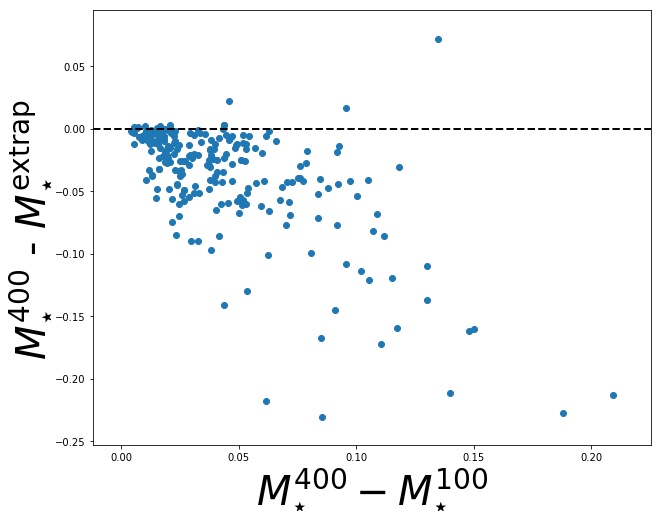

In [51]:
# #fit line
# illustris_diff_cat_1dextrap_params = np.polyfit(catalog_masses, catalog_masses - extrapolated_masses , 1)
# illustris_diff_cat_1dextrap_line = np.poly1d(illustris_diff_cat_1dextrap_params)
# xs=np.linspace(11.2,12.4, 100)



plt.scatter(oned_masses_tng - np.array([oneD_mass(iso,100) for iso in tng_isos]), oned_masses_tng-tng_extrapolated_masses)
#plt.scatter(random_oned_masses_tng, random_oned_masses_tng-random_extrapolated_masses_tng, c='r')

# plt.scatter(tng_catalog_masses, tng_catalog_masses-tng_extrapolated_masses)
# plt.scatter(random_catalog_masses_tng, random_catalog_masses_tng-random_extrapolated_masses_tng, c='r')

# plt.plot(xs, illustris_diff_cat_1dextrap_line(xs))
# plt.text(12, 0.05,'slope: ' + str(illustris_diff_cat_1dextrap_params[0]), fontsize=15)

# plt.ylim([-0.5,0.1])

plt.axhline(0,c="k",linewidth=2,linestyle='--')
plt.ylabel(r'$M_{\star}^{\mathrm{400}}$ - $M_{\star}^{\mathrm{{extrap}}}$ ', fontsize=40)
plt.xlabel('$M_{\star}^{\mathrm{400}} - M_{\star}^{\mathrm{100}} $', fontsize=40)
plt.show